## EDA of Amazon Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
%matplotlib inline
sns.set()
sns.set_style(style='whitegrid')
#sns.set_palette('muted')

In [2]:
parent_path = r'D:\Datasets\amazon_reviews\gzips'

In [16]:
# info: category, num of items, num of users, num of grades, num of 5th, num of 4th, etc

In [3]:
files = [Path(f) for f in glob.glob(parent_path  + r"\*.gz", recursive=False)]

datasets_info = {}

reviewers = set()
asins = set()

for file in files:
    label = ' '.join(file.stem.split('_')[1:-1])
    print('Processing: ' + label)

    num_grades = 0
    counts = 0
    set_reviewers = set()
    set_asins = set()

    chunk_num = 1        
    for df_chunky in pd.read_json(str(file), lines=True, compression = 'gzip', chunksize=1000000):
        print('Chunk #%s' % chunk_num)
        chunk_num += 1
        
        set_asins.update(df_chunky['asin'].unique())
        set_reviewers.update(df_chunky['reviewerID'].unique())
    
        num_grades += df_chunky.shape[0]
        counts += df_chunky.overall.value_counts(sort=False)
    
    datasets_info[label] = {'Unique ASINs': len(set_asins), 'Unique Reviewers': len(set_reviewers), 'Num of Scores': num_grades, 'Counts': counts}
    reviewers.update(set_reviewers)
    asins.update(set_asins)
    

Processing: Books
Chunk #1
Chunk #2
Chunk #3
Chunk #4
Chunk #5
Chunk #6
Chunk #7
Chunk #8
Chunk #9
Processing: CDs and Vinyl
Chunk #1
Chunk #2
Processing: Cell Phones and Accessories
Chunk #1
Processing: Clothing Shoes and Jewelry
Chunk #1
Processing: Electronics
Chunk #1
Chunk #2
Processing: Health and Personal Care
Chunk #1
Processing: Home and Kitchen
Chunk #1
Processing: Kindle Store
Chunk #1
Processing: Movies and TV
Chunk #1
Chunk #2
Processing: Sports and Outdoors
Chunk #1
Processing: Toys and Games
Chunk #1
Processing: Video Games
Chunk #1


In [4]:
print('Total reviewers #%s' % len(reviewers))
print('Total asins #%s' % len(asins))

Total reviewers #1009235
Total asins #663413


In [4]:
# print all categories
print(datasets_info.keys())

dict_keys(['Cell Phones and Accessories', 'Video Games', 'Home and Kitchen', 'Kindle Store', 'Health and Personal Care', 'Clothing Shoes and Jewelry', 'Books', 'CDs and Vinyl', 'Movies and TV', 'Electronics', 'Toys and Games', 'Sports and Outdoors'])


In [5]:
df_data = [(i, datasets_info[i]['Num of Scores'], datasets_info[i]['Unique ASINs'], datasets_info[i]['Unique Reviewers']) + s for i in datasets_info.keys() for s in zip(datasets_info[i]['Counts'].index, datasets_info[i]['Counts'])]
df = pd.DataFrame(df_data, columns = ['Category', 'Num of Scores', 'Unique ASINs', 'Unique Reviewers', 'Rate', 'Rate Count'])

### Calculate sparsity

In [64]:
# sparsity = 1 - #non_zero(A) / #total(A)
sparsity = [(key, 1 - datasets_info[key]['Num of Scores']/(datasets_info[key]['Unique ASINs'] * datasets_info[key]['Unique Reviewers'])) for key in datasets_info.keys()]

In [69]:
sparsity_df = pd.DataFrame.from_dict(dict(enumerate(sparsity)), orient='index', columns=['Category','Sparsity'])

In [70]:
sparsity_df

,Category,Sparsity
0,Movies and TV,0.999726
1,Video Games,0.999106
2,Books,0.999960
3,Electronics,0.999861
4,Kindle Store,0.999767
5,Toys and Games,0.999276
6,Sports and Outdoors,0.999547
7,CDs and Vinyl,0.999774
8,Health and Personal Care,0.999516
9,Clothing Shoes and Jewelry,0.999693


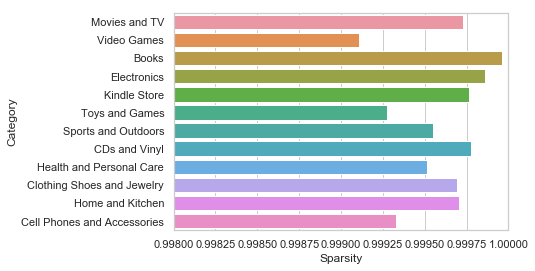

In [80]:
f, ax = plt.subplots()#figsize=(8, 5))
ax.set(xlim=(0.998, 1.0))
sns.barplot(y='Category', x = 'Sparsity', palette='deep', data=sparsity_df, orient = 'h', ax = ax)

### Rates distributions

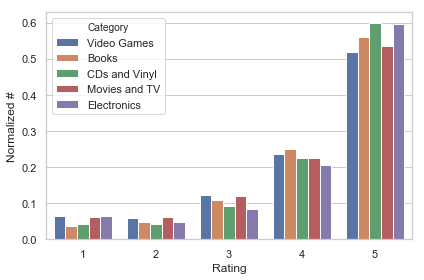

In [12]:
f, ax = plt.subplots()#figsize=(8, 5))

df_percentages = df[df['Category'].isin(['Movies and TV', 'Books', 'CDs and Vinyl', 'Electronics', 'Video Games'])].copy()
sums = df_percentages.groupby('Category')['Rate Count'].sum()
df_percentages['Counts'] = df_percentages.apply(lambda row: row['Rate Count']/sums[row['Category']], axis = 1)

ax = sns.barplot(x="Rate", y="Counts", hue="Category", data=df_percentages, ax = ax)
ax.set(xlabel='Rating', ylabel='Normalized #')
plt.tight_layout()
f.savefig('images/count_distrib.pdf')

In [28]:
avg = 0
total = 0
for rate in range(1, 6):
    rate_counts = df[df['Rate'] == rate]['Rate Count'].sum()
    total += rate_counts
    avg += rate_counts * rate
print("Average dataset rate: %0.2f" % (avg/total))

Average dataset rate: 4.24


### Sizes

C:\Users\irina\Miniconda3\envs\exmc\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


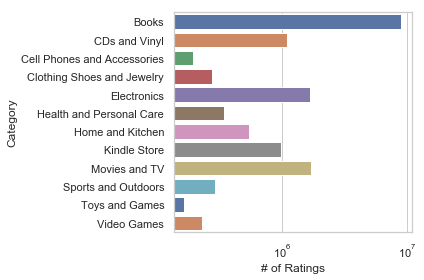

In [107]:
f, ax = plt.subplots()#figsize=(8, 5))
sns.barplot(y='Category', x = 'Num of Scores', data=df, orient = 'h', ax = ax, palette='deep', order = sorted(df['Category'].unique()))

ax.set(xscale="log", xlabel='# of Ratings')
plt.tight_layout()
f.savefig('images/ratings_per_cat.pdf')